#Introduction

We are working with a bike usage dataset in Washington, D.C. which was provided by the [UCI Repository](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset). The dataset itself originates from the Capital Bikeshare system and includes data for the years 2011 and 2012, which has been aggregated from the official [company website](http://capitalbikeshare.com/system-data) by the University of Porto. The publisher of this dataset has also added weather data from [freemeteo.com](http://www.freemeteo.com).

Bike sharing systems are a great way to reduce carbon emissions, especially if they replace car journeys. Our goal is to predict bike usage from weather data. This predictive capability could have significant benefits for businesses, allowing them to proactively deploy more bikes during peak demand periods or adjust fares when usage is expected to be low.

It's important to note that we acknowledge the potential for hindsight bias in our analysis, as weather data of this quality is not available for many days in the future. However, we believe that the dataset is still valuable for predicting bike usage in the near future.

In the following we hypothesize that future bike rental usage can be predicted using this dataset.
Due to the relatively small sample size we decided in advance to not use a validation set and instead use established and tried default hyperparameters for the *mashine learning (ML)* model we would like to use.
As the ML model we decided on the Random Forest Regressor due to its ease of use.

In [2]:
from typing import Dict, Tuple, Optional, Union, List, Any
import requests
import io as io
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy import stats
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns


plt.rcParams['figure.figsize'] = [30, 3]

In [3]:
def get_bike_sharing_dataset_as_dataframes() -> Tuple[
    pd.DataFrame,
    pd.DataFrame
]:
    """
        This function downloads the 'Bike Sharing Dataset' from UC Irvine
        under the assumption that the download link has not changed.
        A tuple of dataframes containing the sampled data is returned.
        The data is not modified.
        However, a column containing a datetime.datetime object is prepended to
        the Dataframe. The date is constructed from sample attributes and is
        included for easier time-series processing.

        Downloaded files are stored in RAM only. To save the files locally
        please call pandas.DataFrame.to_csv.

        URL to repository:
        https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

        URL to files:
        https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip

        returns:
            Tuple[pd.DataFrame, pd.DataFrame]
    """
    u: requests.Response = requests.get(
        "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip"
    )
    f: io.BytesIO = io.BytesIO()
    f.write(u.content)
    input_zip: ZipFile = ZipFile(f)
    extracted: Dict[str, str] = {i: input_zip.read(i) for i in input_zip.namelist()}
    extracted.keys()

    _: io.StringIO = io.StringIO()
    _.write(extracted["hour.csv"].decode("utf-8").replace("\r\n", "\n"))
    _.seek(0)
    hourly_data: pd.DataFrame = pd.read_csv(_, index_col=0)
    hourly_data.insert(
        loc=0,
        column="timestamp",
        value=(
            pd.to_datetime(hourly_data['dteday']) + pd.to_timedelta(hourly_data['hr'], unit='h')
        ).dt.to_pydatetime()
    )

    _: io.StringIO = io.StringIO()
    _.write(extracted["day.csv"].decode("utf-8").replace("\r\n", "\n"))
    _.seek(0)
    daily_data: pd.DataFrame = pd.read_csv(_, index_col=0)
    daily_data.insert(
        loc=0,
        column="timestamp",
        value=(
            pd.to_datetime(daily_data['dteday'])
        ).dt.to_pydatetime()
    )

    return (hourly_data, daily_data)

In [4]:
hourly_data, daily_data = get_bike_sharing_dataset_as_dataframes()

##Bike Sharing Dataset:

The bike rental data set contains the following information:

| column | explanation |
| --- | ---|
| Date | Each row corresponds to a specific date. |
| Season | The season of the year, categorized as spring(1), summer(2), fall(3), or winter(4). |
| Year | Indicates whether the year is 2011 (0) or 2012 (1). |
| Month | The month of the year, from January (1) to December (12). |
| Hour | The time of day, from 0 (midnight) to 23 (11 PM). |
| Holiday | Shows whether it is a holiday (1) or a regular day (0). |
| Day of the Week | Indicates which day of the week it is (Sunday is 0 and Saturday is 6). |
| Working Day | Specifies whether it is a regular workday (1) or a weekend/holiday (0). |
| Weather | Describes the weather condition on a scale of 1 to 4. |
| Temperature | The normalized temperature to the maximum temperature of 41 degrees Celsius. |
| Feeling Temperature | How warm it feels, with values normalized to a maximum of 50 degrees Celsius. |
| Humidity | The level of moisture in the air, with values ranging from 0% to 100%. |
| Wind Speed | The wind speed normalized to a maximum speed of 67 km/h. |
| Casual Users | The number of people who rented bikes casually (not registered users). |
| Registered Users | The number of registered bike users that rented a bike. |
| Total Rentals | The total number of bikes rented, including both casual and registered users. |

In [5]:
daily_data.head()

,timestamp,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
train_test_split = 0.8  # split between train + vaildate and test

sample_size = len(daily_data.index) #731

daily_train = daily_data.copy()[:int(sample_size*train_test_split)]
daily_test = daily_data.copy()[int(sample_size*train_test_split):]

#Preprocessing

The bike sharing dataset that we used for our task was already complete and therefore no imputation of missing values was needed. All features are numerically ancoded as well and we thus do not need to encode categorical data either. We, however, did modify the weather situdation data since there are only 21 instances of bad weather and no instances of very bad weather. Thus we reduced the weather situation to:

"1" = good

"2" = bad

In [7]:
daily_train.weathersit = daily_train["weathersit"].map(lambda x: 2 if x==3 else x)

#Exploratory Data Analysis

Before taking a look at the data we were biased by personal experience that weather and temperature impact the eagerness to ride bicycles. That is the reason why we wanted to focus and explore this assumed correlation.

## Investigating The Impact Of Temperature On Bike Rental Count

In the following we explore if there is correlation between the temperature and the bike rental count as we are biased by our own weather experiences and would like to confirm or disprove this notion.

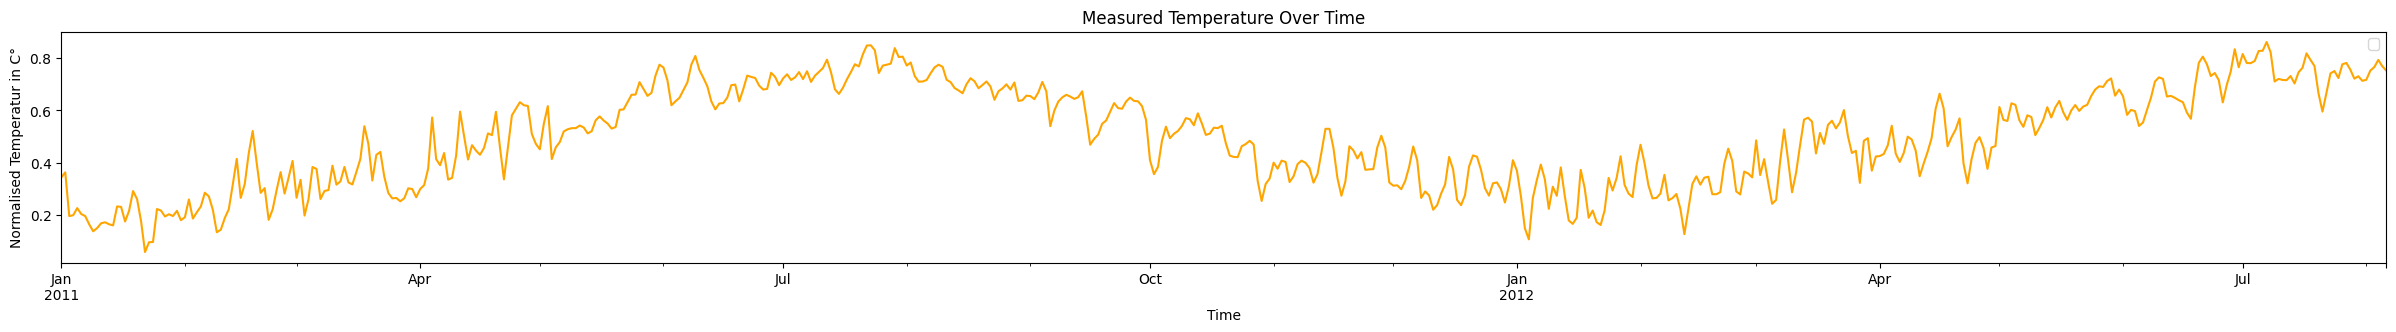

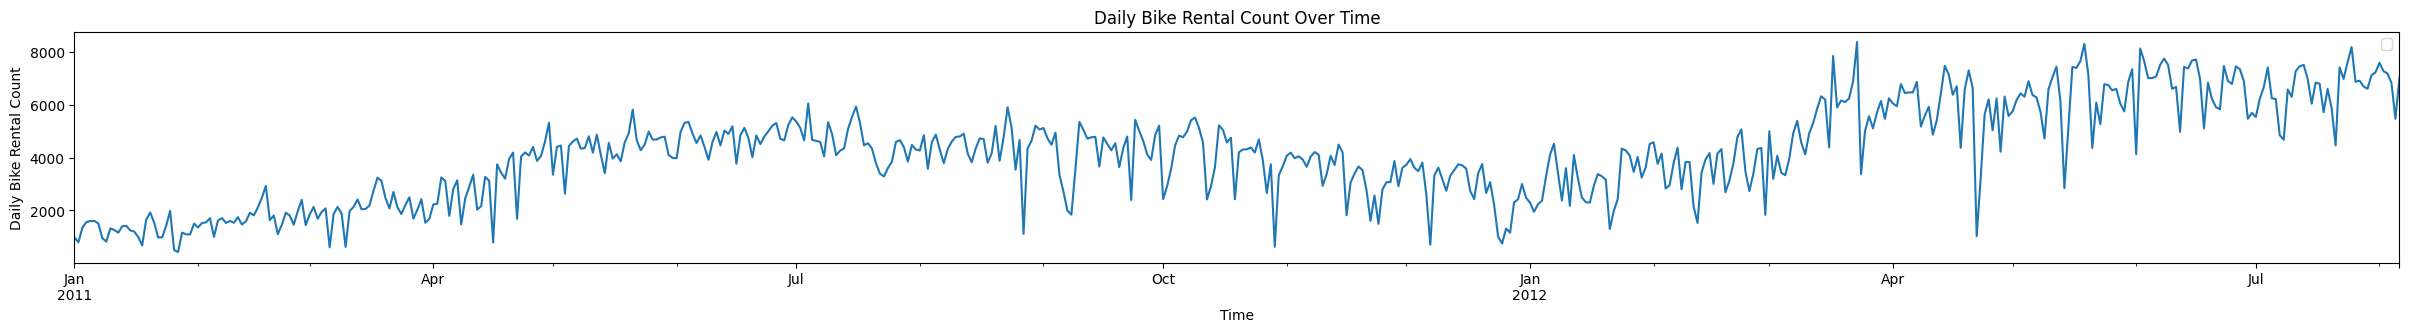

In [8]:
tmp_plot = daily_train.plot(
    x="timestamp",
    y=["temp"],
    xlabel="Time",
    ylabel="Normalised Temperatur in C°",
    title="Measured Temperature Over Time",
    color="orange"
)
tmp_plot.legend(())
plt.show()

cnt_plot = daily_train.plot(
    x="timestamp",
    y=["cnt"],
    ylabel="Daily Bike Rental Count",
    xlabel="Time",
    title="Daily Bike Rental Count Over Time",
)
cnt_plot.legend(())
plt.show()

The graph representing the daily bike rental count, reveals a pattern of yearly periodicity on visual inspection. It is evident that during the summer months, there is a notable increase in bike users compared to the winter months. It is possible that this trend is related to temperature variations. These assumptions will be tested in the sections below.

Notably, the daily bike rental count exhibits a lack of smoothness, mirroring the fluctuations in temperature. The spikes are particularly prominent when moving in a negative direction. These might indicate anomalies like extreme, in other words bad, weather. This assumption will be tested in the following as well.

## Investigating The Impact Of Weather Situation On Bike Rental Count

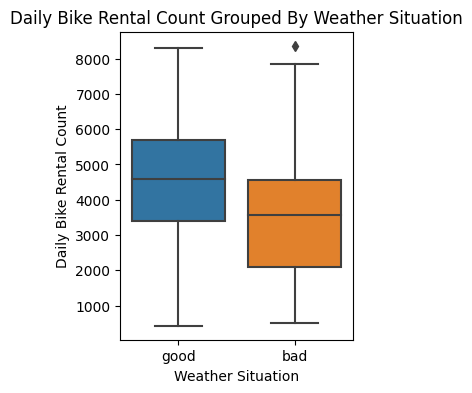

,min,mean,max,std,sem,count
weathersit,,,,,,
bad,506,3504.690821,8362,1691.712311,117.582134,207
good,431,4509.896552,8294,1742.076644,89.721512,377


In [9]:
daily_data_w= daily_train.copy()
daily_data_w["weathersit"] = daily_data_w["weathersit"].replace({1: "good", 2: "bad"})

plt.figure(figsize = [3,4])
sns.boxplot(data=daily_data_w, x="weathersit", y="cnt", order=["good", "bad"])
plt.title("Daily Bike Rental Count Grouped By Weather Situation")
plt.suptitle("")  # Remove the default title
plt.xlabel("Weather Situation")
plt.ylabel("Daily Bike Rental Count")
plt.show()
daily_data_w.groupby("weathersit").cnt.aggregate(["min", "mean", "max", "std", "sem", "count"])

In this boxplot it looks like bad weather impacts the bike usage differently than good weather does.

The mean of bad weather is below the mean of good weather.

The interquartile ranges are shifted as expected, but surpisingly the total ranges of the daily bike rental count do not seem to differ by a lot.

# Hypothesis Testing

## Impact Of The Weather Situation

To assess the influence of the weather situation, we conducted the following hypothesis test:

**H0**: There is **no significant difference** in the impact **between good** weather and **bad** weather (both have equal true means).

**H1**: There is a **significant difference** in impacts between **good weather** and **bad** weather (true means are not equal).

We have chosen a significance level of 5%.

To test this we have chosen to perform a two-sided T-test for two indepoendant samples with differing sample size. We have chosen this test due to the fact that we wanted to discern if the means are significantly different. We are unable to perform a Z-test as the true variance is unknown.



In [10]:
alpha = 5 / 100
p_val = sc.stats.ttest_ind(
    a=daily_train.cnt[daily_train.weathersit == 1],  # "good" weather
    b=daily_train.cnt[daily_train.weathersit == 2],  # "bad" weather
    equal_var=False
).pvalue

print(f"Certainty of H0 being acceptable: {p_val * 100} %")

if p_val < alpha / 2:
    print("H0 can be rejected. Bad and good weather have significantly different impact on bike rental count.")

if p_val > alpha / 2:
    print("H1 can be rejected. Bad and good weather have no significantly different impact on bike rental count.")

Certainty of H0 being acceptable: 3.547859579916642e-09 %
H0 can be rejected. Bad and good weather have significantly different impact on bike rental count.


##Temperature Impact On Bike Rental Count

We anticipate greater bike usage in response to higher temperatures. To investigate this, we normalized both temperature and bike usage, calculating the difference between them. Additionally, we computed the Pearson correlation coefficient (Pearson-r) to assess the strength and direction of an assumed linear relationship.

                0
min      0.001532
mean     0.643573
max      2.668926
std      0.463996
count  584.000000


<Axes: title={'center': 'Difference between normalised Count and Temperature'}, xlabel='Date', ylabel='Difference'>

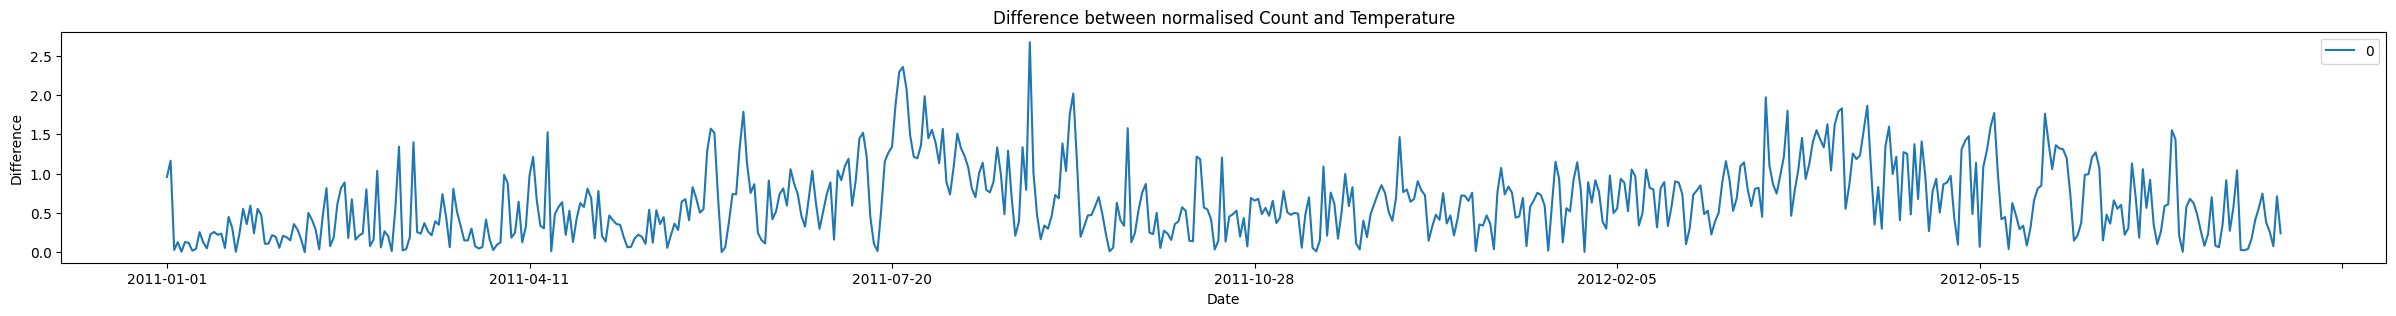

In [11]:
tmp_n = daily_train.temp.map(lambda x: (x-daily_train.temp.mean())/daily_train.temp.std())
cnt_n = daily_train.cnt.map(lambda x: (x-daily_train.cnt.mean())/daily_train.cnt.std())
diff = pd.DataFrame((cnt_n-tmp_n).map(lambda x: x if x>0 else -x))
print(diff.agg(["min", "mean", "max", "std", "count"]))
diff["date"] = daily_train.dteday
diff.plot(x="date",xlabel="Date", ylabel="Difference", title = "Difference between normalised Count and Temperature")

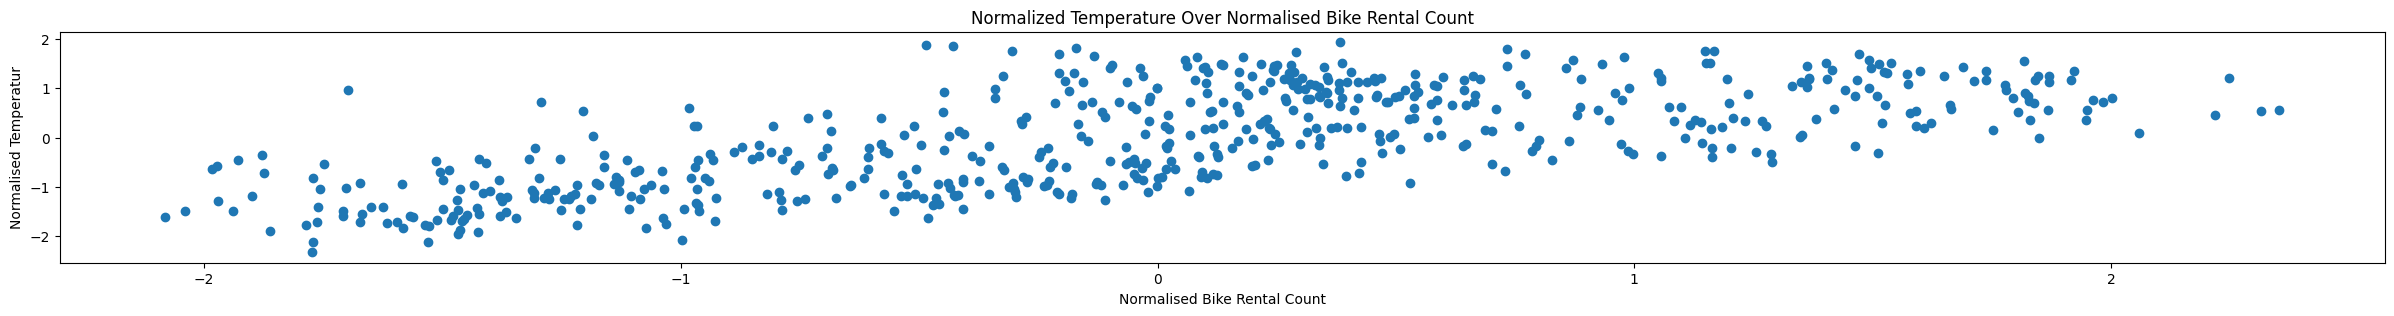

Pearson correlation coefficient: 0.6849055151199045


In [12]:
fig, ax = plt.subplots()
ax.scatter(x=cnt_n, y=tmp_n)  # , label ="Datapoint per day with correspoding Temperatur and Count")
ax.set_ylabel("Normalised Temperatur")
ax.set_xlabel("Normalised Bike Rental Count")
plt.title("Normalized Temperature Over Normalised Bike Rental Count")
# plt.legend(loc="upper right")
plt.show()
print("Pearson correlation coefficient:", stats.pearsonr(x=cnt_n, y=tmp_n).statistic)

The Pearson correlation coefficient equals to 0.68 when considering the normalized bike rental count and normalized temperature. This indicates a correlation between temperature and the daily rentals count. Looking at the graph above, we can see that during the summer of 2011, the difference between temperature and rentals count is the highest. We might expect that when temperatures become extremely high, the relationship between temperature and ride count becomes weaker.

#Feature Engineering

Include the "instant" column to the dataset. This column will serve as an input for the Random Forest model and will replace the date as the scikit-learn implementation can not operate on datetime.datetime objects.

In [13]:
daily_train["instant"] = daily_train.index
daily_test["instant"] = daily_test.index

We are performing exponentially moving average to filter out high frequency components in the bike rental count smoothing out anomalies.

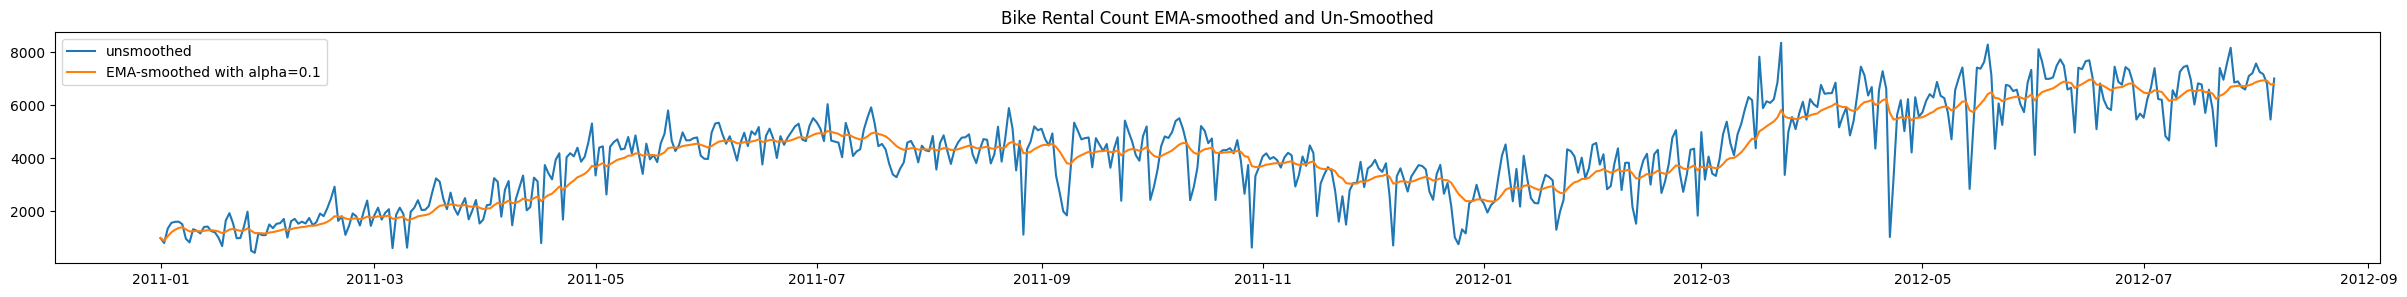

In [14]:
alpha: float = 0.1
daily_train["cnt_smoothed"] = daily_train["cnt"].ewm(alpha=alpha, adjust=True).mean()


plt.plot(daily_train.timestamp, daily_train["cnt"], label="unsmoothed")
plt.plot(daily_train.timestamp, daily_train["cnt_smoothed"], label=f"EMA-smoothed with alpha={alpha}")
plt.title("Bike Rental Count EMA-smoothed and Un-Smoothed")
plt.legend()
plt.show()

Our goal is to construct an engineered feature for our Random Forest Regressor Model which quantifies an underlying trend in the bike rental count.

For this we assume that the time series follows a multiplicative model where seasonality moderates the underlying linear trend, which is assumed by us.
To inspect the impact of periodic influences we perform a Fourrier Transform on the data and inspect the attained spectrum.

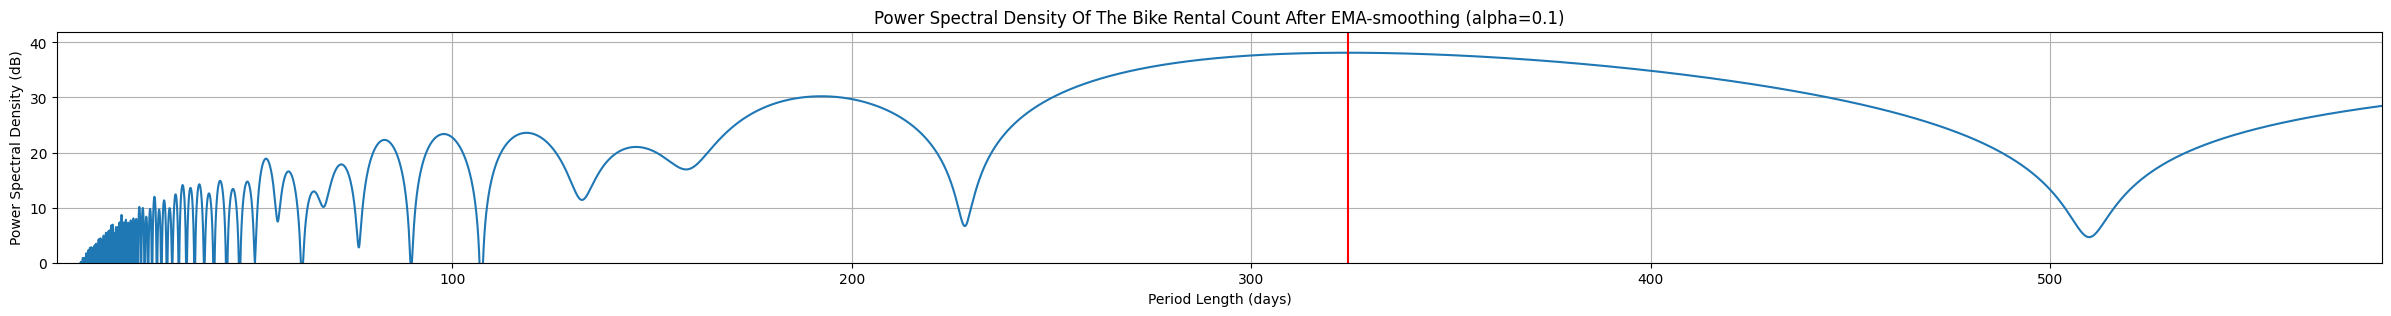

Period with greatest impact: 324.09 days at 38.13 dB


In [15]:
# remove offset to prevent spike around 0 Hz which encodes no useful information
signal: pd.Series = daily_train["cnt_smoothed"].ewm(alpha=alpha).mean()
signal -= signal.mean()
sampling_period: float = 1 * 24 * 60 ** 2  # 1 day in seconds
sampling_frequency: float = 1 / sampling_period
sample_size: int = len(signal)
# zero-pad signal to get higher fft resolution
padded_signal: np.ndarray = np.pad(signal, 5000 * 365)

# perform FFT and normalize components
amplitudes: np.ndarray = np.fft.fft(padded_signal) * 2 / sample_size
frequencies: np.ndarray = np.fft.fftfreq(len(padded_signal), d=sampling_period)

# remove 0 Hz component
amplitudes = amplitudes[1:]
frequencies = frequencies[1:]

# remove negative frequencies
amplitudes = amplitudes[frequencies > 0]
frequencies = frequencies[frequencies > 0]

# convert frequencies to cycle length in days
periods_in_days = 1 / frequencies / (24 * 60 ** 2)

_max_days: float = (
    daily_train["timestamp"].max() - daily_train["timestamp"].min()
).days

# throw away all periods larger than sampling duration
_: np.ndarray = periods_in_days < _max_days
amplitudes = amplitudes[_]
frequencies = frequencies[_]
periods_in_days = periods_in_days[_]

# get period with greatest power
max_influence_cycle_idx: int = np.argmax(np.abs(amplitudes))
max_influence_cycle: float = periods_in_days[max_influence_cycle_idx]

# plot spectral power
plt.figure()
plt.plot(periods_in_days, 10 * np.log10(np.power(np.abs(amplitudes), 2) / sample_size))
plt.xlabel('Period Length (days)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Power Spectral Density Of The Bike Rental Count After EMA-smoothing (alpha=0.1)')

_y_max: float = 10 * np.log10(np.power(np.abs(amplitudes[max_influence_cycle_idx]), 2) / sample_size)
plt.vlines(
    x=max_influence_cycle,
    ymin=0,
    ymax=1.5 * _y_max,
    color="red"
)

plt.ylim([0, 1.1 * _y_max])
plt.xlim([1, _max_days])
plt.grid(True)
plt.show()

print(f"Period with greatest impact: {np.round(max_influence_cycle, 2)} days at {np.round(_y_max, 2)} dB")

When inspecting the power spectral density (PSD) we can see that a period of 324 days has the greatest impact on the bike rental count. Considering that our training data contains samples for a duration of less than two years and that we assume yearly weather changes to impact the bike count, we can infer that the peak is caused by spectral leakage from the 365 day cycle.
We thus continue engineering our feature under the assumption that a 365 day cycle influences an underlying linear trend.

In the following we reconstruct the seasonal impact by generating a sine signal from the fourrier coefficents.

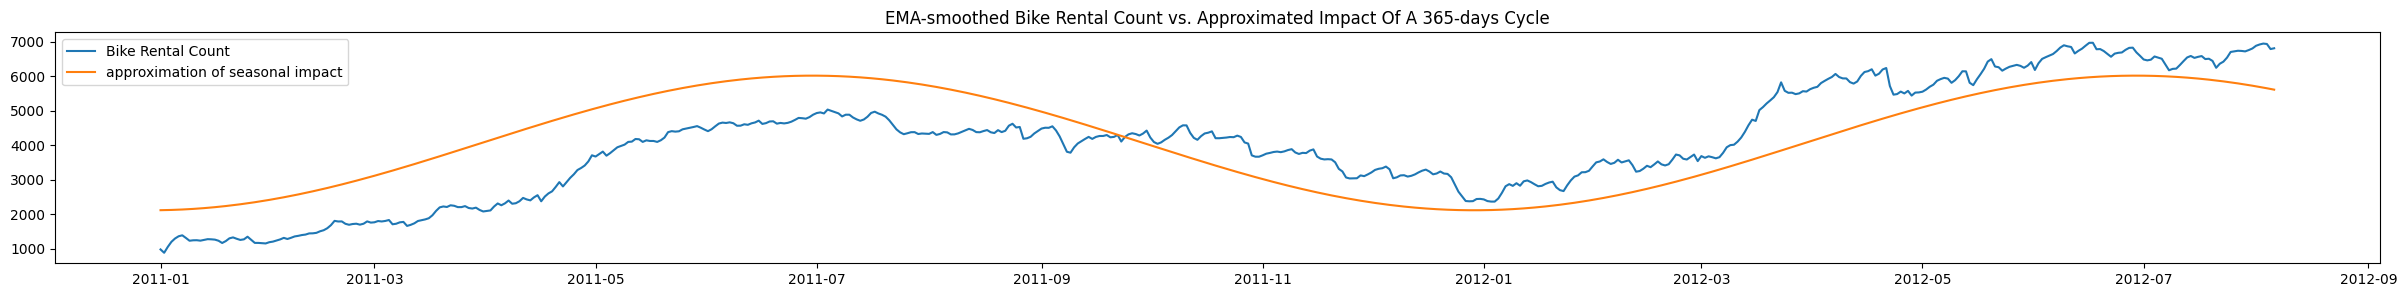

Spearman correlation of bike rental count and approximated seasonal impact: 0.7891258253364566


In [16]:
amplitude: float = np.abs(amplitudes[max_influence_cycle_idx])
phase_shift: float = np.angle(amplitudes[max_influence_cycle_idx]) + np.pi  # phase shift correction from EMA filter
_cycle_length: float = 365  # max_influence_cycle
_freq: float = 1 / (_cycle_length * sampling_period)
_t: np.ndarray = np.arange(len(daily_train.index)) * sampling_period
sin_approx_of_season_impact: np.ndarray = amplitude * np.sin(2 * np.pi * _t * _freq + phase_shift)
approx: np.ndarray = sin_approx_of_season_impact + daily_train.cnt_smoothed.mean()


plt.title("EMA-smoothed Bike Rental Count vs. Approximated Impact Of A 365-days Cycle")
plt.plot(daily_train.timestamp, daily_train.cnt_smoothed, label="Bike Rental Count")
plt.plot(daily_train.timestamp, approx, label="approximation of seasonal impact")
# plt.plot(daily_data_training.timestamp, daily_data_training.cnt_smoothed / _approx, label="cnt_smoothed divided by approx")
plt.legend()
plt.show()

s_r = sc.stats.spearmanr(daily_train['cnt_smoothed'], sin_approx_of_season_impact).statistic

print(
    f"Spearman correlation of bike rental count and approximated seasonal impact: {s_r}"
)

The generated sine signal has an amplitude of 1948.32 and a phase of 4.76.

When visually inspecting the bike rental count, we see that the sine signal follows the underlying fluctuations of the rental count. Further inspection of non-linear correlation using Spearman's Rho shows that a correlation is present.

As we are assuming a multiplicative time series model we can now extract the underlying linear trend by dividing the bike rental count by our approximated seasonal impact.

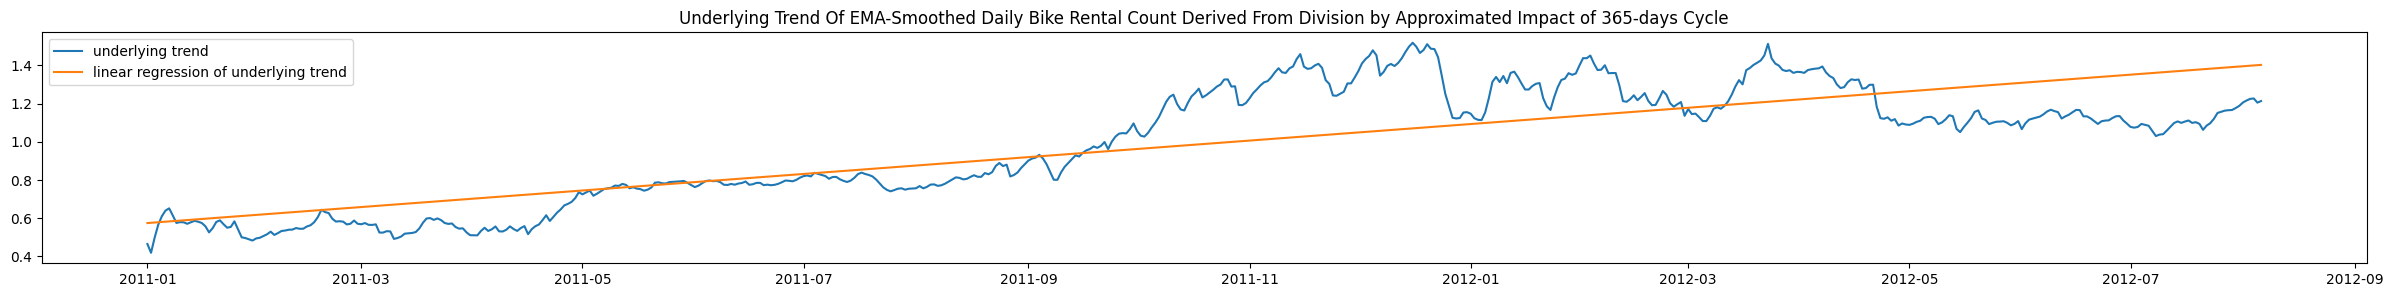

Pearson correlation of underlying trend of bike rental count with its linear regression: 0.8080242898425408


In [17]:
under_lying_trend: np.ndarray = daily_train.cnt_smoothed / approx
_t: np.ndarray = np.arange(len(daily_train.index)) * sampling_period
slope, intercept, r, p, se = sc.stats.linregress(_t, under_lying_trend)

plt.title("Underlying Trend Of EMA-Smoothed Daily Bike Rental Count Derived From Division by Approximated Impact of 365-days Cycle")

plt.plot(daily_train.timestamp, under_lying_trend, label="underlying trend")
plt.plot(daily_train.timestamp, slope * _t + intercept, label="linear regression of underlying trend")
plt.legend()
plt.show()

s_r = sc.stats.spearmanr(under_lying_trend, slope * _t + intercept).statistic
print(
    f"Pearson correlation of underlying trend of bike rental count with its linear regression: {r}"
)

The parameters of the linear regession are:

**slope**: 1.6450818155224215e-08

**intercept**: 0.574186887624875

The linear regression fits the calculated underlying trend well. The Spearman correlation coefficient is 0.8. With such an high coefficient we can safely confirm that a linear model fits the underyling trend.

Using the parameters for our approximated seasonal impact and the parameters of our linear regression we can now construct and formalise our engineered feature.

We first compare it to the EMA-smoothed and un-smoothed bike rental count.

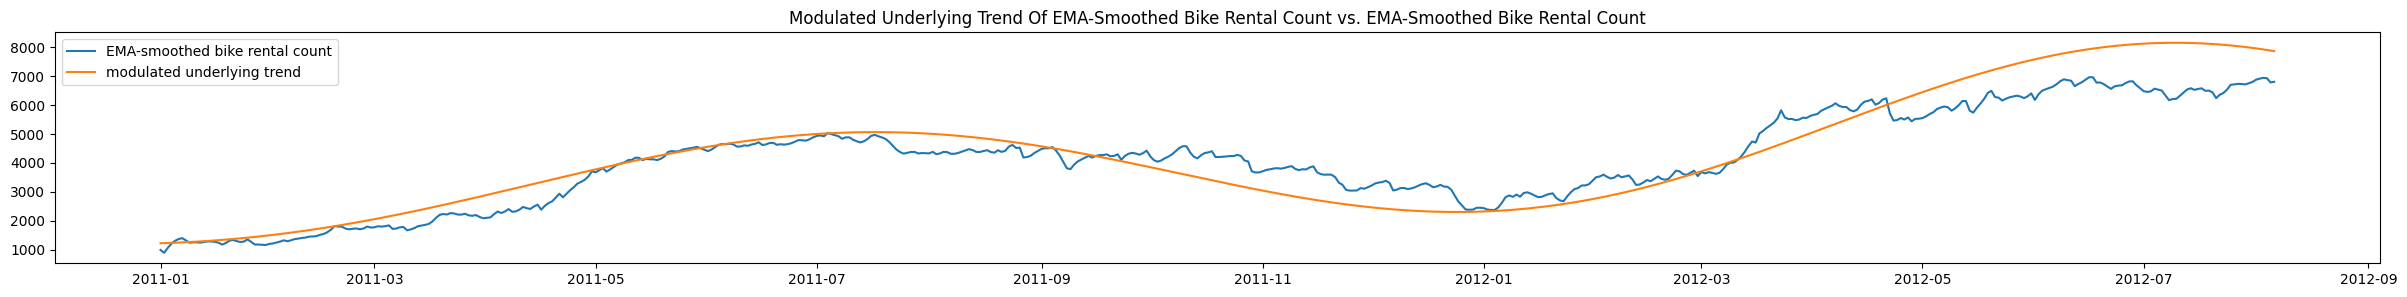

Spearman correlation of modulated underlying trend and bike rental count: 0.9577436090230093


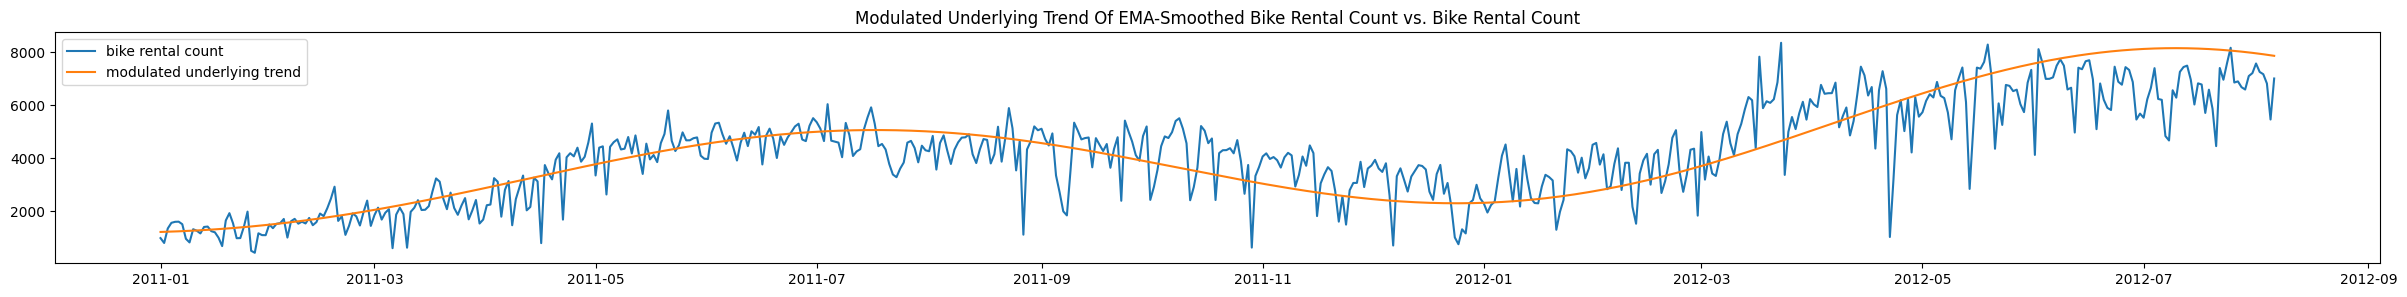

Spearman correlation of modulated underlying trend and bike rental count: 0.8529513464563087


#############################


linear regression parameters:
slope: 1.6450818155224215e-08
intercept: 0.574186887624875


modulating sine signal:
amplidtude: 1948.321612411066
phase: 4.758387784875196
frequency (Hz): 3.1709791983764586e-08
period length (days): 365


In [18]:
_t: np.ndarray = np.arange(len(daily_train.index)) * sampling_period

under_lying_trend = slope * _t + intercept
_cycle_length: float = 365  # max_influence_cycle
_freq: float = 1 / (_cycle_length * sampling_period)

sin_approx_of_season_impact: np.ndarray = amplitude * np.sin(2 * np.pi * _t * _freq + phase_shift) + daily_train.cnt_smoothed.mean()

modulated_linear_regression: np.ndarray = under_lying_trend * sin_approx_of_season_impact

plt.plot(daily_train.timestamp, daily_train.cnt_smoothed, label="EMA-smoothed bike rental count")
plt.plot(daily_train.timestamp, modulated_linear_regression, label="modulated underlying trend")
plt.title("Modulated Underlying Trend Of EMA-Smoothed Bike Rental Count vs. EMA-Smoothed Bike Rental Count")
plt.legend()
plt.show()

s_r = sc.stats.spearmanr(modulated_linear_regression, daily_train.cnt_smoothed).statistic
print(
    f"Spearman correlation of modulated underlying trend and bike rental count: {s_r}"
)

plt.plot(daily_train.timestamp, daily_train.cnt, label="bike rental count")
plt.plot(daily_train.timestamp, modulated_linear_regression, label="modulated underlying trend")
plt.title("Modulated Underlying Trend Of EMA-Smoothed Bike Rental Count vs. Bike Rental Count")
plt.legend()
plt.show()

s_r = sc.stats.spearmanr(modulated_linear_regression, daily_train.cnt).statistic
print(
    f"Spearman correlation of modulated underlying trend and bike rental count: {s_r}"
)
print("\n\n#############################\n\n")

print("linear regression parameters:")
print(f"slope: {slope}")
print(f"intercept: {intercept}")

print("\n")
print("modulating sine signal:")
print(f"amplidtude: {amplitude}")
print(f"phase: {phase_shift}")
print(f"frequency (Hz): {_freq}")
print(f"period length (days): {_cycle_length}")

Interpreting the plots and the calculated spearman correlation coefficients we can confirm that our engineered feature fits the bike rental count well.
In the following we formalise the construction of this feature as a python function for further use with our chosen ML model.

In [19]:
def get_engineered_feature(
    date: Union[datetime, pd.Series],
    slope: float = slope,
    intercept: float = intercept,
    amplidtude: float = amplitude,
    phase: float = phase_shift,
    frequency: float = _freq,
    bias: float = daily_train.cnt.mean(),
    sampling_period: float = 24 * 60 ** 2,
) -> Union[float, np.ndarray]:
    def __calculate_multiplicative_time_series(the_date: Union[datetime, pd.Series]) -> float:
        start_date: datetime = datetime(year=2011, month=1, day=1)
        number_of_day: float = (the_date - start_date).days
        result: float = slope * sampling_period * number_of_day + intercept
        result *= (amplidtude * np.sin(2 * np.pi * frequency * number_of_day * sampling_period + phase) + bias)
        return result
    if isinstance(date, datetime):
        return __calculate_multiplicative_time_series(date)
    if isinstance(date, pd.Series):
        return np.array(list(map(__calculate_multiplicative_time_series, date)))

As an academic excercise we evaluate our engineered feature as a learner by itself before integrating it into the Random Forest Regressor, which is our actual ML model.

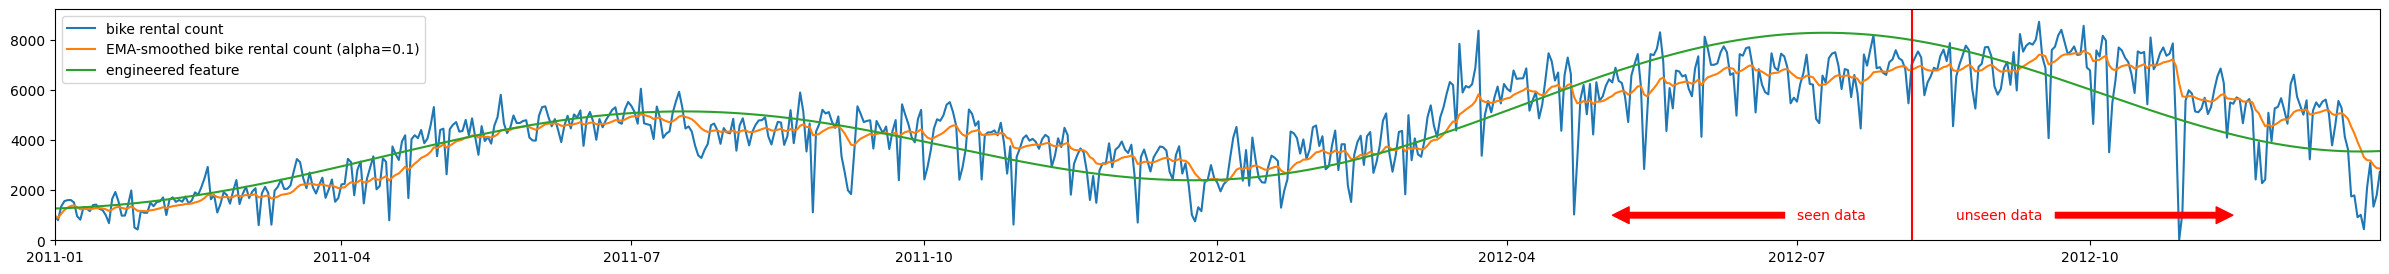

In [20]:
plt.rcParams['figure.figsize'] = [30, 3]
daily_data["cnt_smoothed"] = daily_data.cnt.ewm(alpha=0.1).mean()

plt.plot(daily_data.timestamp, daily_data.cnt, label="bike rental count")
plt.plot(daily_data.timestamp, daily_data.cnt_smoothed, label="EMA-smoothed bike rental count (alpha=0.1)")
plt.plot(
    daily_data.timestamp,
    get_engineered_feature(
        daily_data.timestamp
    ),
    label="engineered feature"
)

plt.vlines(
    x=daily_train.timestamp.max(),
    ymin=0,
    ymax=daily_data.cnt.max() + 500,
    color="red"
)

plt.annotate(
    "seen data",
    xy=(datetime(year=2012, month=5, day=1), 1000),
    xytext=(datetime(year=2012, month=7, day=1), 1000),
    arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05),
    verticalalignment="center",
    color="red"
)

plt.annotate(
    "unseen data",
    xy=(datetime(year=2012, month=11, day=18), 1000),
    xytext=(
        datetime(year=2012, month=8, day=20)
        , 1000
    ),
    arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05),
    verticalalignment="center",
    color="red"
)

plt.xlim(
    [daily_data.timestamp.min(), daily_data.timestamp.max()]
)
plt.ylim(
    [0, daily_data.cnt.max() + 500]
)
plt.legend()
plt.show()

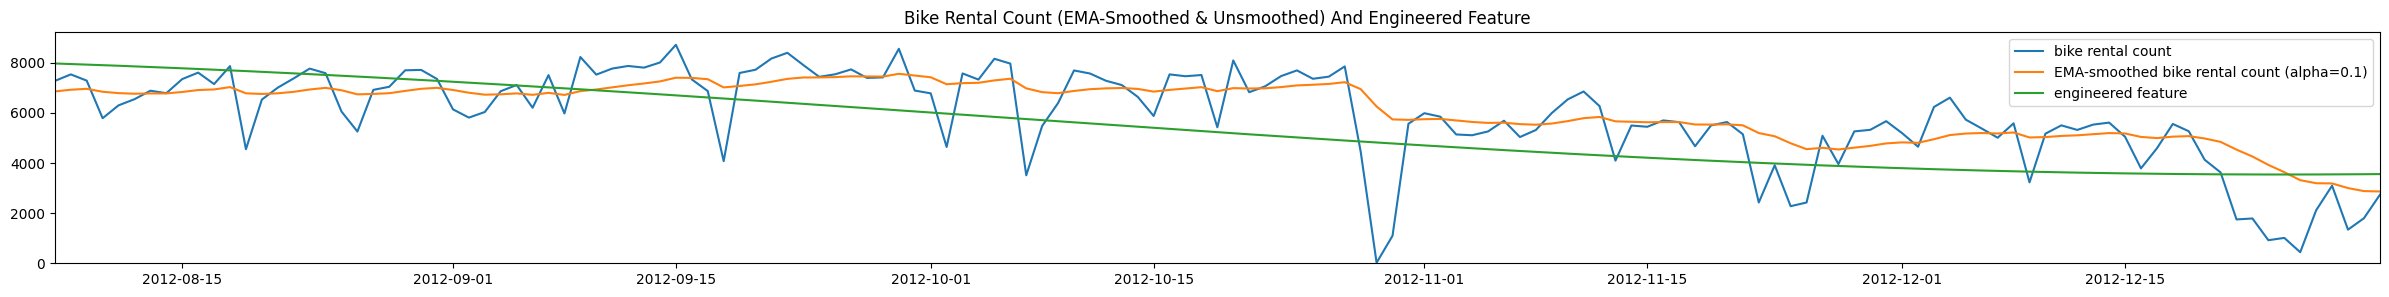

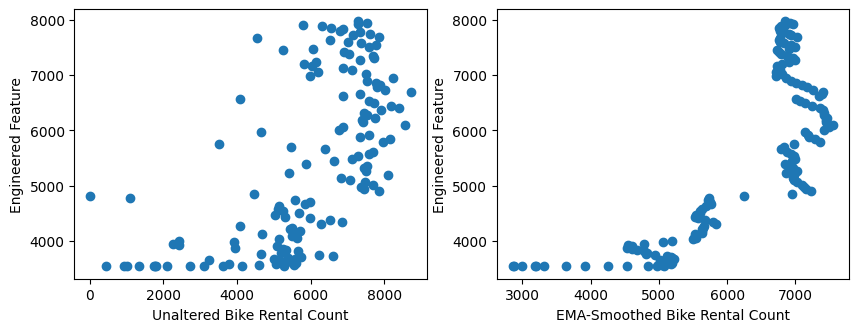

Spearman correlation of engineered feature and unaltered bike rental count: 0.6687079886401714
Pearson correlation of engineered feature and unaltered bike rental count: 0.6159016475936628

Spearman correlation of engineered feature and EMA-smoothed bike rental count: 0.7194198671693779
Pearson correlation of engineered feature and EMA-smoothed bike rental count: 0.7852827811452414

R2-score of engineered feature to unaltered bike rental count: 0.2804412482087859
R2-score of engineered feature to EMA-smoothed bike rental count: -0.06193860463056167


In [21]:
_selector = (daily_data.timestamp > daily_train.timestamp.max())

_time_axis: pd.Series = daily_data[_selector].timestamp
_unaltered_cnt: pd.Series = daily_data[_selector].cnt
_smoothed_cnt: pd.Series = daily_data[_selector].cnt_smoothed
_forecast_cnt: np.ndarray = get_engineered_feature(
    daily_data[_selector].timestamp
)

plt.plot(
    _time_axis,
    _unaltered_cnt,
    label="bike rental count"
)
plt.plot(
    _time_axis,
    _smoothed_cnt,
    label="EMA-smoothed bike rental count (alpha=0.1)"
)
plt.plot(
    _time_axis,
    _forecast_cnt,
    label="engineered feature"
)

plt.xlim(
    [daily_data[_selector].timestamp.min(), daily_data.timestamp.max()]
)
plt.ylim(
    [0, daily_data.cnt.max() + 500]
)
plt.legend()
plt.title(
    "Bike Rental Count (EMA-Smoothed & Unsmoothed) And Engineered Feature"
)
plt.show()



_old_settings = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 3.5]


fig, axs = plt.subplots(1, 2)

axs[0].scatter(
    _unaltered_cnt, _forecast_cnt
)
axs[0].set_xlabel("Unaltered Bike Rental Count")
axs[0].set_ylabel("Engineered Feature")
# plt.show()

axs[1].scatter(
    _smoothed_cnt, _forecast_cnt
)
axs[1].set_xlabel("EMA-Smoothed Bike Rental Count")
axs[1].set_ylabel("Engineered Feature")
plt.show()
plt.rcParams['figure.figsize'] = _old_settings

s_r = sc.stats.spearmanr(_unaltered_cnt, _forecast_cnt).statistic
p_r = sc.stats.pearsonr(_unaltered_cnt, _forecast_cnt).statistic
print(
    f"Spearman correlation of engineered feature and unaltered bike rental count: {s_r}"
)
print(
    f"Pearson correlation of engineered feature and unaltered bike rental count: {p_r}"
)

print()
s_r = sc.stats.spearmanr(_smoothed_cnt, _forecast_cnt).statistic
p_r = sc.stats.pearsonr(_smoothed_cnt, _forecast_cnt).statistic
print(
    f"Spearman correlation of engineered feature and EMA-smoothed bike rental count: {s_r}"
)
print(
    f"Pearson correlation of engineered feature and EMA-smoothed bike rental count: {p_r}"
)

r2_score_unaltered = r2_score(
    y_true=_unaltered_cnt,
    y_pred=_forecast_cnt
)
r2_score_smoothed = r2_score(
    y_true=_smoothed_cnt,
    y_pred=_forecast_cnt
)
print()
print(f"R2-score of engineered feature to unaltered bike rental count: {r2_score_unaltered}")
print(f"R2-score of engineered feature to EMA-smoothed bike rental count: {r2_score_smoothed}")

The correlation analysis and visual comparisons of the plots indicate that our engineered feature highly correlates with the actual time series and its EMA-smoothed version. However, when looking at the R2-score, it is evident that the predictions are generally not very accurate.

Our engineered feature performs better when predicting the actual time series, achieving an R2-score of around 0.28, which offers somewhat usable predictions. However, this is not the case when predicting the EMA-smoothed version, where the R2-score is negative. In other words, the model performs worse than simply averaging the smoothed time series. Comparing the negative R2-score with a Pearson correlation of 0.78 we can conclude that the engineered feature overfits the EMA-smoothed time series.

In the following we calculate our engineered feature for our training and test data.

In [22]:
try:
    daily_data_training = daily_train.reset_index()
    all_daily_data = daily_data.reset_index()
except ValueError:
    pass

daily_train["engineered_feature"] = get_engineered_feature(
    daily_train.timestamp
)

daily_test["engineered_feature"] = get_engineered_feature(
    daily_test.timestamp
)

# Random Forest Regression

Random Forest Regression is a bagging method for regression. Tree base learners are produced by bootstrapping and predictions are aggregated into a final prediction. Bootstrapping here is performed by training the decision trees on a random sample with a subset of the features. The decision trees are built by minimmizing error functions like the mean squared error.

$MSE(x) = \frac{1}{n} \sum_{i=1}^{n} (Y_i-\hat{Y_i})^2$

Aggregation can be preformed by averaging the results.

$
\hat{y}(x) = \frac{1}{n} \sum_{j=1}^{n} T_j(x)
$
with $T_j(x)$ being the outcome of a tree.

We assume that weather forecasts are accurate enough and that data containing weather information can be used for predictions. We, however, acknowledge that using it might induce hindsight bias. The influence of this bias should be investigated in a future study.

We thus decide to use all features as well as our own calculated regression model as a feature for our random forest regression.

In [23]:
features_list: List[str] = [
    "instant",
    "season",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
    "engineered_feature"
]

## Performance Evaluation Of Our Random Forest Regressor On The Training Data

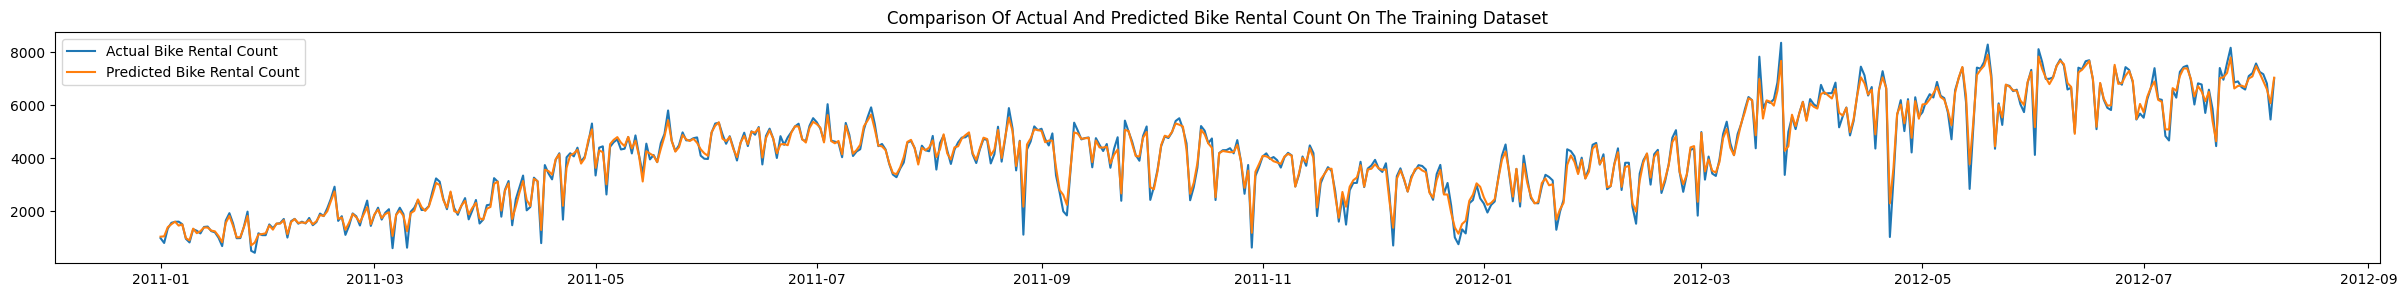

R2-score: 0.9854788653730252


In [29]:
cols: List[str] = []
cols.extend(features_list)

X = daily_train[cols]
Y = daily_train["cnt"]
regr = RandomForestRegressor()
regr.fit(X, Y)

predictions: np.ndarray = regr.predict(daily_train[cols])

plt.plot(daily_train.timestamp, daily_train.cnt, label="Actual Bike Rental Count")
plt.plot(daily_train.timestamp, predictions, label="Predicted Bike Rental Count")
plt.title("Comparison Of Actual And Predicted Bike Rental Count On The Training Dataset")
plt.legend()
plt.show()

r2score = r2_score(
    y_true=daily_train.cnt,
    y_pred=predictions
)

print(f"R2-score: {r2score}")

As can be seen from the graph and the R2-score the random forest regressor fits the bike rental count almost perfectly.

## Performance Evaluation Of Our Random Forest Regressor On The Test Data

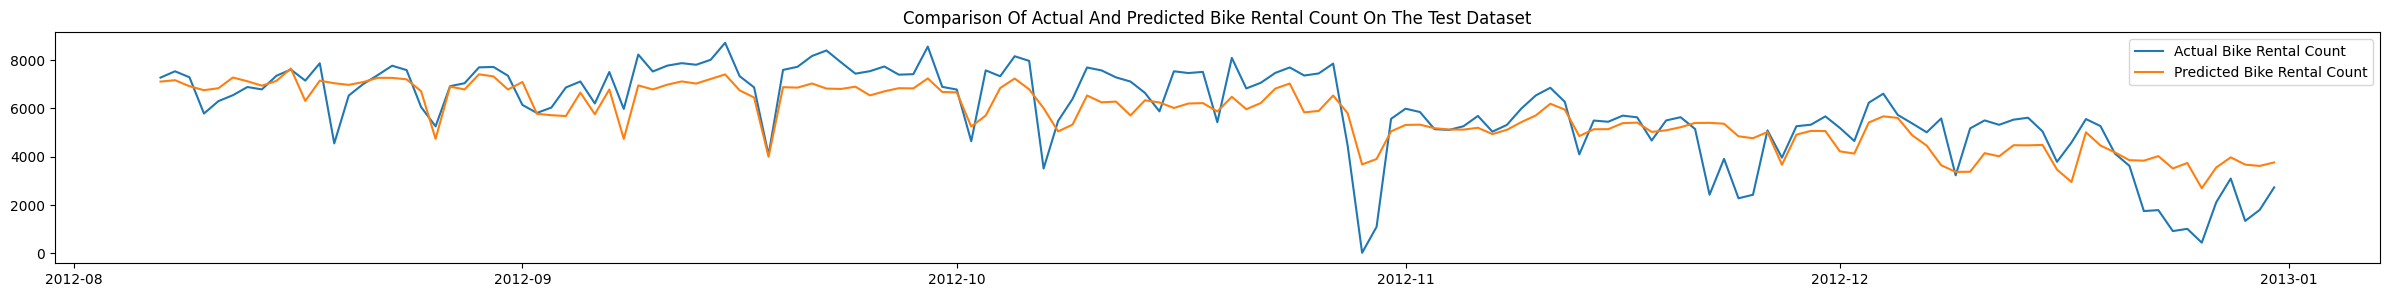

R2-score: 0.6432344984785046


In [30]:
predictions: np.ndarray = regr.predict(daily_test[cols])

plt.plot(daily_test.timestamp, daily_test.cnt, label="Actual Bike Rental Count")
plt.plot(daily_test.timestamp, predictions, label="Predicted Bike Rental Count")
plt.title("Comparison Of Actual And Predicted Bike Rental Count On The Test Dataset")
plt.legend()
plt.show()

r2score = r2_score(
    y_true=daily_test.cnt,
    y_pred=predictions
)

print(f"R2-score: {r2score}")

#Conclusion

Working with a time series presented more challenges than we initially expected since random data selection is not feasible. We anticipate better results with a larger dataset. A seasonal dataset spanning just two years is not ideal. We performed fourier analysis which can normally only be done on time series where the total sampling time is a multiple greater than 2 of the largest period length under inspection. Otherwise a different approach might offer better results, which we should investigate in a future study.

The performance of the Random Forest Regression model on the traing data is very good, with a R2-score of 0.98. Random Forest Regression works well with many features and generally has a high R2-score on training data.

The resulting R2-score on the test data of around 0.65 is decent, although not outstanding, it can be further improved. We believe that multiple factors influence bike rental counts, which are not quantified by this dataset. We assume that there is a maximum achievable R2-score with the available data, which should be investigated in the future as well.

As we mentioned in the introduction, we are mindful of a potential hindsight bias. In the best-case scenario, our model could provide predictions for one or two days in advance. However, with the advancements in weather forecasting, it may still offer a useful approximation.

#References

1.  Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:[10.1007/s13748-013-0040-3](https://doi.org/10.1007/s13748-013-0040-3). UCI DOI: https://doi.org/10.24432/C5W894

2.  [Numpy](https://numpy.org/): Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: [10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2). \([Publisher link](https://www.nature.com/articles/s41586-020-2649-2)\).

3.  [Scikit-learn: Machine Learning in Python](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

4.  [SciPy](https://scipy.org/) 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17(3), 261-272, DOI: [10.1038/s41592-019-0686-2](https://doi.org/10.1038/s41592-019-0686-2)

5.  [Pandas](https://pandas.pydata.org/): pandas-dev/pandas: Pandas, The pandas development team, DOI: [10.5281/zenodo.3509134](https://doi.org/10.5281/zenodo.3509134)

6.  [Seaborn](https://seaborn.pydata.org/): statistical data visualization. Journal of Open Source Software, Michael L. Waskom, Vol. 6, Number 60, DOI: [10.21105/joss.03021](https://doi.org/10.21105/joss.03021)

7.  [Matplotlib](https://matplotlib.org/stable/index.html): J. D. Hunter, "Matplotlib: A 2D Graphics Environment", Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007. DOI: [10.1109/MCSE.2007.55](https://doi.org/10.1109/MCSE.2007.55)
